# County-to-county Inflow Migration

### Documentation for network analysis on inflow migrations

### Sections
1. Import modules needed
2. Data preprocessing
3. Filtering individual states after getting total node and edge lists
4. Network and community visualizations for states

### Main Goals

* Redo Ohio county inflow graph in Python
* Create reproduceable code that makes inflow community graphs for every state
* Later on: look at longer distance moves, so maybe going to counties from other states


# Section 1: Import Modules Needed

In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pylab
from cdlib import algorithms,viz
from matplotlib import colormaps
from urllib.request import urlopen
import json
import plotly.express as px
import leidenalg as la
import igraph as ig

# Section 2: Data Preprocessing

This section has the function that: 

* Imports the csv county data from the IRS website
* Changes column names to standardize them in case we use different `inflow` files from other years
* Filters out total migration, non-migrants, and foreign migrants
* Filters out rows that have 40 or less migrants total
* Creates target county names and target county states through an inner join
* Creates our node and edge list of counties and states that can be used in our network graphs


## Standardize the TargetStateFips column of our TotalEdgeList, to match the FIPS of the USA graph values
* TargetCountyFIPS that have two digits will have a leading zero, one digit will have two leading zeros
* TargetStateFIPS that have one digit will have one leading zero
* Concat these two values into one column `TotalFips`

In [33]:
# Pass in the url for our county inflow csv from IRS site
def CleanData(url):
    raw_df = pd.read_csv(url, encoding='latin-1')
    df = pd.DataFrame(raw_df)

    # Change column names based on IRS info
    df.rename(columns={'y2_statefips': 'TargetStateFips', 'y2_countyfips': 'TargetCountyFips', 'y1_statefips': 'OriginStateFips',
                       'y1_countyfips': 'OriginCountyFips', 'y1_state': 'OriginState', 'y1_countyname': 'OriginCountyName',
                       'n1': 'ReturnNum', 'n2': 'IndividualsNum'}, inplace=True)

    # Filter out all origin state fips greater than 56
    df = df[df['OriginStateFips'] <= 56]
    # Remove rows that have 40 or less migrants
    df = df[df['ReturnNum'] > 40]
    # Filter our origin county names that have the strings: Non-migrants, and Foreign
    df = df[~df['OriginCountyName'].str.contains('Non-migrants|Foreign')]

    # Create target countyname and target state name. We need these target county names to add into our edgelist as the 'Target'
    TargetTable = df[['OriginCountyName', 'OriginState', 'OriginStateFips', 'OriginCountyFips']].copy()
    TargetTable.drop_duplicates(inplace=True)

    # Rename columns for the target information
    TargetTable.rename(columns={'OriginCountyName': 'TargetCountyName', 'OriginState': 'TargetState', 
                                'OriginStateFips': 'TargetStateFips', 'OriginCountyFips': 'TargetCountyFips'}, inplace=True)

    # Merge with the main dataframe
    Merge = pd.merge(
        df, 
        TargetTable[['TargetStateFips', 'TargetCountyFips', 'TargetState', 'TargetCountyName']], 
        left_on=['TargetStateFips', 'TargetCountyFips'], 
        right_on=['TargetStateFips', 'TargetCountyFips'],
        how='inner' 
    )

    # Remove 'County' or 'county' from OriginCountyName and TargetCountyName
    Merge['OriginCountyName'] = Merge['OriginCountyName'].str.replace('County', '', case=False)
    Merge['TargetCountyName'] = Merge['TargetCountyName'].str.replace('County', '', case=False)

    # Create a node and edgelist of counties within the states. 
    TotalNodeList = Merge[['TargetCountyFips', 'TargetCountyName', 'TargetState']]
    TotalNodeList = TotalNodeList.sort_values(by='TargetCountyFips')
    TotalNodeList.rename(columns={'TargetCountyFips': 'CountyFips', 'TargetCountyName': 'CountyName', 'TargetState': 'State'}, inplace=True)
    TotalNodeList.drop_duplicates(inplace=True)


    TotalEdgeList = Merge[['OriginState', 'OriginCountyName', 'TargetState', 'TargetCountyName', 'ReturnNum', 'agi', 'OriginCountyFips',
                           'TargetCountyFips', 'TargetStateFips', 'OriginStateFips']]
    TotalEdgeList.drop_duplicates(inplace=True)
    TotalEdgeList.sort_values(by=['OriginState', 'OriginCountyName'], inplace=True)

    # Adjusting FIPS columns in TotalEdgeList
    TotalEdgeList['TargetCountyFips'] = TotalEdgeList['TargetCountyFips'].astype(str).str.zfill(3)  # Ensure 3 digits
    TotalEdgeList['TargetStateFips'] = TotalEdgeList['TargetStateFips'].astype(str).str.zfill(2)    # Ensure 2 digits

    # Create TargetTotalFips by concatenating TargetStateFips and TargetCountyFips
    TotalEdgeList['TargetTotalFips'] = TotalEdgeList['TargetStateFips'] + TotalEdgeList['TargetCountyFips']

    # Preview the modified DataFrame
    print('You can now access "TotalNodeList" and "TotalEdgeList" tables for further use!')
    return TotalNodeList, TotalEdgeList
    return df
    
# Running this function will return the cleaned Node and Edge list required for our network graphs! 
# We can pass in any county-inflow csv link through the IRS site
TotalNodeList, TotalEdgeList = CleanData(url='https://www.irs.gov/pub/irs-soi/countyinflow2122.csv')

You can now access "TotalNodeList" and "TotalEdgeList" tables for further use!


# Section 3: Filtering individual states after getting total node and edge lists

Our goal in this section is to make a function that:
* Returns custom node and edge lists by specifying which state you want the target(inflow) state to be.
* For example, passing in `TargetState='AK'` into the parameter will create a node and edge list specifically for the state of Alaska, only looking at in-state county migration.

In [24]:
# TODO: Create function named StateNodeAndEdges(TargetState)
def StateNodesAndEdges(TargetState):
    
    # Create conditions for passing abbrevs. in the TargetState value and return the correct node and edgelist that it specifies
    StateNodeList = TotalNodeList[TotalNodeList['State'] == TargetState]
    StateNodeList.sort_values(by='CountyName', ascending=True, inplace=True)
    
    StateEdgeList = TotalEdgeList[
        (TotalEdgeList['TargetState'] == TargetState) & 
        (TotalEdgeList['OriginState'] == TargetState)
    ]
    StateEdgeList.sort_values(by='OriginCountyName', ascending=True, inplace=True)
    StateEdgeList['TargetCountyFips'] = StateEdgeList['TargetCountyFips'].astype(str)
    
    # Return the new node and edge lists for specific states and distances
    print('Returned state node and edgelist for: ' + TargetState + '\nTable names returned: StateNodeList, StateEdgeList')
    return StateNodeList, StateEdgeList

# Type in the abbreviation for your state as a string value and pass it into the TargetState parameter
StateNodeList, StateEdgeList = StateNodesAndEdges(TargetState='OH')

Returned state node and edgelist for: OH
Table names returned: StateNodeList, StateEdgeList


# Section 4: Network creation and community visualizations for state graphs

This section creates a function that:
* Draws graph which has the size of each node representing their degree centrality, and colors of their node by their community.
* Because of our previous filtering, nodes that had 40 or less migrants have been removed for consistency.
* A barchart that shows the top 10 counties in your state by the highest degree centrality, which represents how many edges are connected to the specific node

Simply pass in the `StateEdgeList` and `StateNodeList` dataframes that you created in the previous function into the `CreateGraph(StateEdgeList, StateNodeList)` function to get the community graph and centrality barchart.

<Figure size 1800x1800 with 0 Axes>

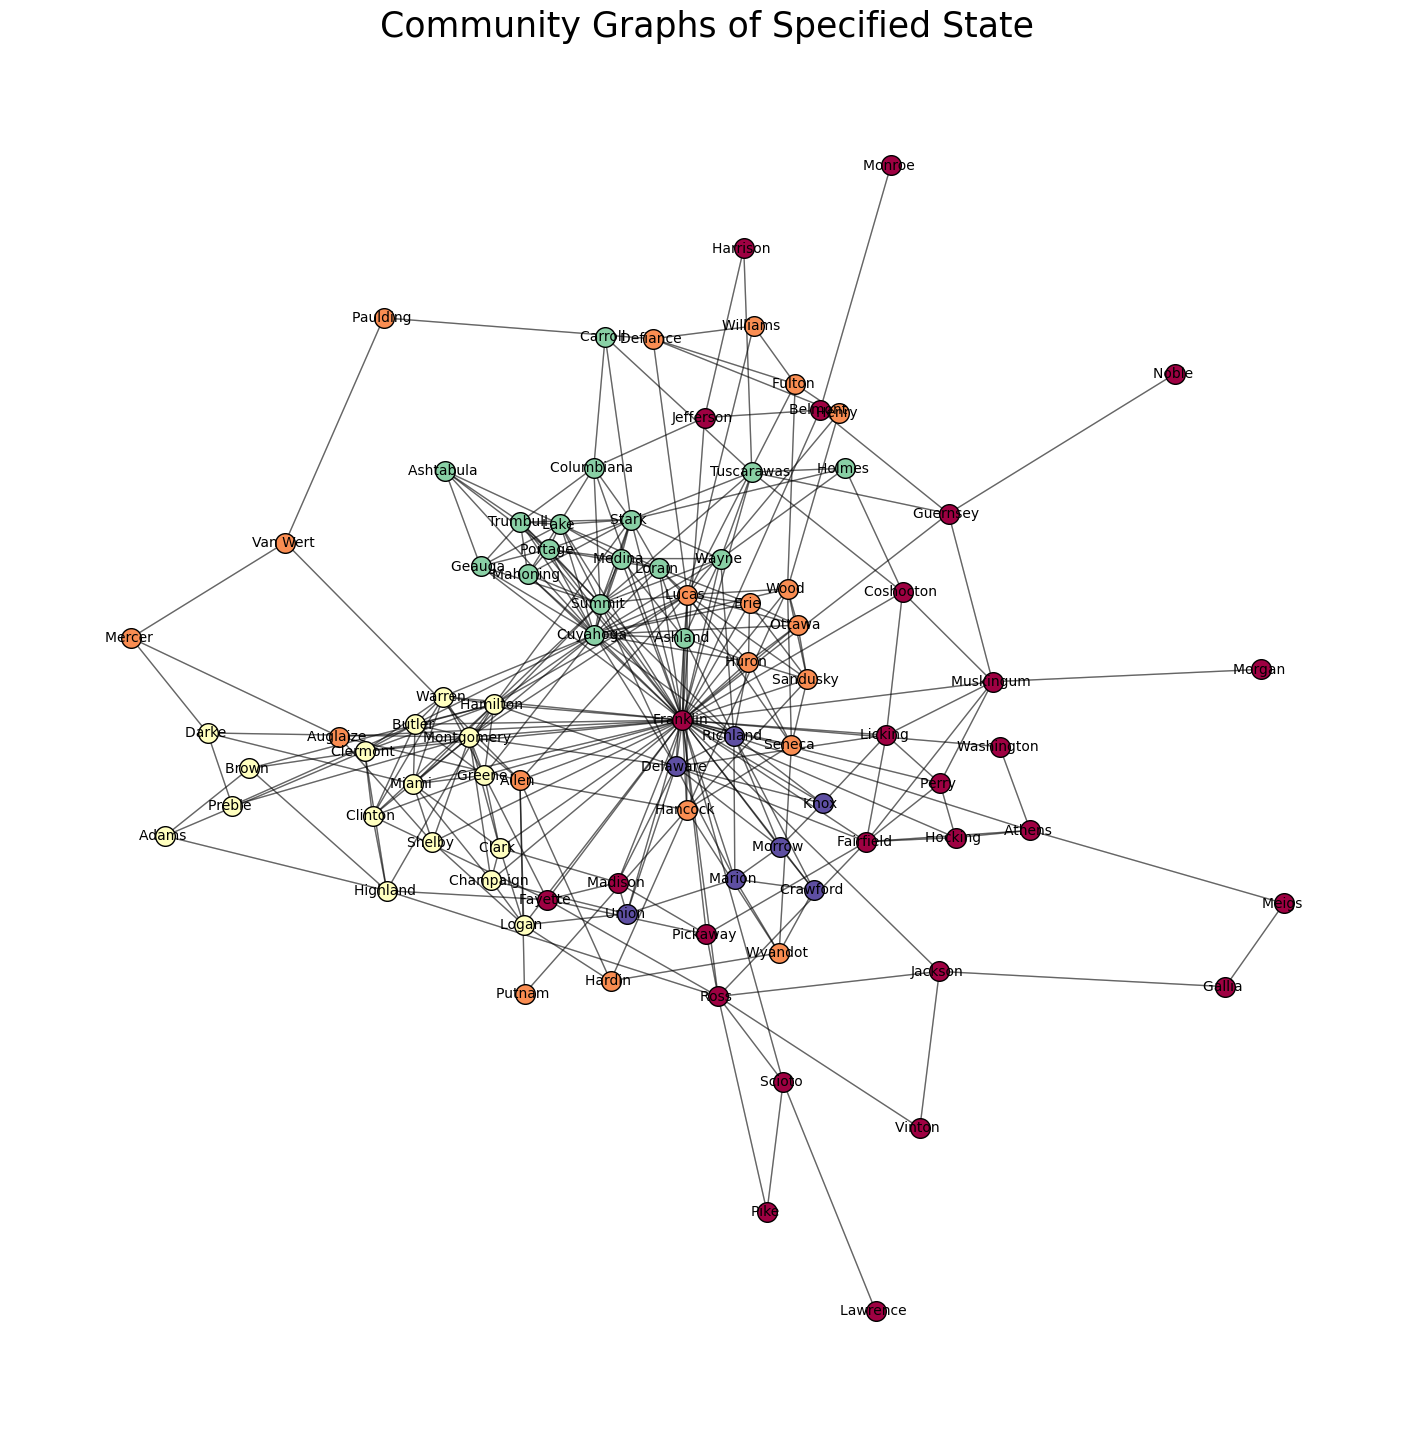

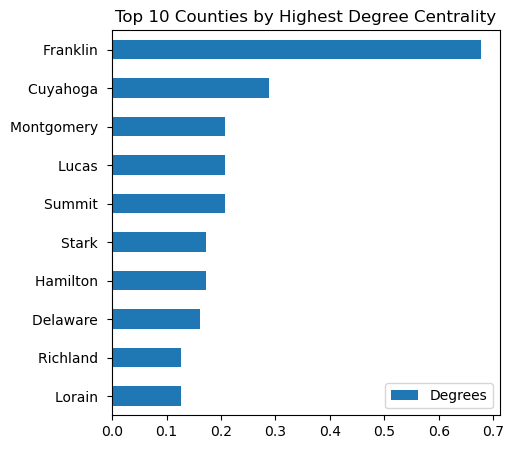

In [29]:
def CreateStateGraph(StateEdgeList, StateNodeList):
    # Generate the graph based on our state edge list
    G = nx.from_pandas_edgelist(StateEdgeList, source='OriginCountyName', target='TargetCountyName', edge_attr='ReturnNum')
    
    # Use the CDLib library to get our Louvain algorithm for community detection
    communities = algorithms.leiden(G)
        
    # Calculate degree centrality for our node sizes
    DegreeCentrality = nx.degree_centrality(G)
        
    # Scale node sizes based on degree centrality
    NodeSizes = [DegreeCentrality[node] * 7000 for node in G.nodes()]
    
    # Set our spring layout for the graph and random seed = 42 so we can get reproducible results
    position = nx.spring_layout(G, seed=42)
    
    # Set the plot's background color to light gray
    plt.figure(figsize=(18, 18))
    
    # Plot network clusters with community coloring
    viz.plot_network_clusters(G, communities, position, node_size=NodeSizes, figsize=(18, 18), cmap='Spectral', show_node_sizes=True)
        
    # Draw in our edges and node labels and give our graph a title
    nx.draw_networkx_edges(G, position, alpha=0.2)
    nx.draw_networkx_labels(G, position, font_size=10)  # Adding a semi-colon gets rid of the dictionary output
    plt.title('Community Graphs of Specified State', fontsize=25)
    
    # Create a dataframe of degree centralities for our bar chart
    DegreeCentralityDict = dict(nx.degree_centrality(G))
    DegreeCentralityDf = pd.DataFrame(DegreeCentralityDict, index=[0]).T
    DegreeCentralityDf.columns = ['Degrees']
    DegreeCentralityDf.sort_values('Degrees', inplace=True, ascending=False)
    DegreeCentralityDf.head(10)

    # Give our bar chart a title and output it
    title = 'Top 10 Counties by Highest Degree Centrality'
    _ = DegreeCentralityDf[0:10].plot.barh(title=title, figsize=(5, 5))
    plt.gca().invert_yaxis()

CreateStateGraph(StateEdgeList, StateNodeList)

In [9]:
def CleanUSData(TotalEdgeList):
    # Generate the graph based on the total edge list
    G = nx.from_pandas_edgelist(TotalEdgeList, source='OriginCountyName', target='TargetCountyName', edge_attr='ReturnNum')
    
    # Use the CDLib library to get our Louvain algorithm for community detection
    communities = algorithms.leiden(G)
    
    # Create a dictionary mapping each node (county) to its community
    CommunityDict = {node: cid for cid, community in enumerate(communities.communities) for node in community}
    
    # Convert the community dictionary into a DataFrame
    CommunityDf = pd.DataFrame(list(CommunityDict.items()), columns=['CountyName', 'Community'])
    
    # Sort the dataframe by community for easier interpretation
    CommunityDf.sort_values('Community', inplace=True)
    
    # Reset the index for a clean presentation
    CommunityDf.reset_index(drop=True, inplace=True)
    
    # Join the community dataframe onto the TotalEdgeList to identify which county belongs to each community
    CountyDf = pd.merge(
                    TotalEdgeList,
                    CommunityDf,
                    how='inner',
                    left_on='TargetCountyName',
                    right_on='CountyName',
                )
    
    print('You can now access CountyDf to create the US Map')
    return CountyDf, CommunityDf
    
# Output
CountyDf, CommunityDf = CleanUSData(TotalEdgeList)

You can now access CountyDf to create the US Map
